# Predicción de pérdida de clientes en Empresas de Servicios de Telecomunicaciones (Churn)

Reducir las salidas y [deserciones de clientes](https://www.bain.com/insights/breaking-the-back-of-customer-churn/) se ha convertido en una alta prioridad para la mayoría de los proveedores de servicios de comunicaciones a medida que los mercados maduran y la competencia se intensifica.




En este documento usaremos una base de datos de una empresa de telecomunicaciones anónima [disponibilizada por IBM](https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv).

El principal objetivo es crear un model de aprendizaje automático basado en SVM y Regresión Logística (Logistic Regression, LR) para predecir la pérdida o salida de clientes en una empresa de telecomunicaciones.


Jefferson Astudillo 

Sebastian Guiterrez

## Librerías

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


## Base de datos

Este conjunto de datos contiene un total de 7043 clientes y 21 características de los mismos. De las entradas, 5174 son clientes activos y 1869 son clientes que la empresa ha perdido. Observe que el conjunto de datos está desbalanceado pues por cada cliente perdido existe casi 3 clientes activos. La variable de salida para nuestro modelo de machine learning será `Churn`.

In [2]:
# importamos dataset
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# vemos las primeras 5 filas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### *Detalles de la base de datos*

*	`customerID` - Custumer unique identifier
*	`gender` - Customer gender - ['Female' 'Male']
*	`SeniorCitizen` - Elderly or retired person, a senior citizen is someone who has at least attained the age of 60 of 65 years
*	`Partner` - - ['No' 'Yes']
*	`Dependents` - If customer has dependents - ['No' 'Yes']
*	`Tenure` - Customer lifespan (in months)
*	`PhoneService` - - ['No' 'Yes']
*	`MultipleLines` - - ['No' 'No phone service' 'Yes']
*	`InternetService` - - ['No' 'No internet service' 'Yes']
*	`OnlineSecurity` - - ['No' 'No internet service' 'Yes']
*	`OnlineBackup` - - ['No' 'No internet service' 'Yes']
*	`DeviceProtection` - - ['No' 'No internet service' 'Yes']
*	`TechSupport` - - ['No' 'No internet service' 'Yes']
*	`StreamingTV` - - ['No' 'No internet service' 'Yes']
*	`StreamingMovies` -  - ['No' 'No internet service' 'Yes']
*	`Contract` - Type of contract - ['Month-to-month' 'One year' 'Two year']
*	`PaperlessBilling` - - ['No' 'Yes']
*	`PaymentMethod` - payment method - ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']
*	`MonthlyCharges` - Monthly Recurring Charges
*	`TotalCharges` - Life time value
*	`Churn` - Churn value, the targer vector - ['No' 'Yes']





### *Limpieza del Dataset*

La función get_df_size se utiliza para obtener información básica sobre el tamaño del conjunto de datos, en términos de su número de atributos y entradas.

Luego, se reemplazan los valores en blanco por NaN (valores faltantes) en el dataframe utilizando la función replace de pandas. Se reemplazan los valores faltantes en la columna TotalCharges por la mediana de los valores no faltantes de la misma columna, utilizando la función fillna de pandas. Además, se convierte esta columna de tipo objeto a tipo numérico utilizando la función apply de pandas y el método pd.to_numeric.

A continuación, se elimina la columna customerID, ya que no es una característica relevante para el modelo. Se utiliza el método drop de pandas para eliminar la columna, especificando el argumento axis=1 para indicar que se está eliminando una columna y no una fila.

Por último, se utiliza la función describe de pandas para obtener estadísticas descriptivas del conjunto de datos preprocesado y se imprimen en pantalla la cantidad de instancias con valor "Yes" y "No" en la variable objetivo Churn.

In [3]:
def get_df_size(df, header='Dataset dimensions'):
  print(header,
        '\n# Attributes: ', df.shape[1],
        '\n# Entries: ', df.shape[0],'\n')

get_df_size(df)

#df.info()

# reemplaza valores en blanco por NaN
df_clean = df.replace(r'^\s*$', np.nan, regex=True)


# Convert 'TotalCharges' to numeric before calculating the median.
# errors='coerce' will handle any non-numeric values by setting them to NaN.
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')

# reemplaza valores faltantes en TotalCharges por la mediana de TotalCharges.
total_charges_median = df_clean.TotalCharges.median()


df_clean['TotalCharges'].fillna(total_charges_median, inplace=True)
df_clean['TotalCharges'] = df_clean['TotalCharges'].apply(pd.to_numeric)

#CustomerID lo retiramos porque no es una característica
df_clean = df_clean.drop('customerID', axis=1)
df_clean.describe()

print("Churn No Instances: ", df_clean[df_clean['Churn'] == 'No'].shape[0])
print("Churn Yes Instances: ", df_clean[df_clean['Churn'] == 'Yes'].shape[0])


Dataset dimensions 
# Attributes:  21 
# Entries:  7043 

Churn No Instances:  5174
Churn Yes Instances:  1869


C:\Users\jeff_\AppData\Local\Temp\ipykernel_25008\1680099738.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['TotalCharges'].fillna(total_charges_median, inplace=True)


## Preparación de la Base de Datos








Este código realiza la preprocesamiento de los datos en el dataframe df_clean para poder usarlo en un modelo de machine learning. En primer lugar, identifica las características binarias, numéricas y categóricas en el conjunto de datos. Luego, crea una copia del dataframe original y realiza las siguientes operaciones sobre él:

Convierte las características binarias en etiquetas numéricas mediante el uso de LabelEncoder().
Crea variables dummy para las características categóricas usando pd.get_dummies().
Imprime la información del tamaño del conjunto de datos original y procesado utilizando la función get_df_size().
Retorna un nuevo dataframe df_proc que contiene todas las características preprocesadas y que puede ser utilizado en un modelo de machine learning.
En resumen, el código realiza la limpieza, transformación y preparación de los datos para su posterior uso en un modelo de machine learning.

In [4]:
binary_feat = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
numeric_feat = [col for col in df_clean.select_dtypes(['float','int']).columns.tolist() if col not in binary_feat]
categorical_feat = [ col for col in df_clean.select_dtypes('object').columns.to_list() if col not in binary_feat + numeric_feat ]
df_proc = df_clean.copy()
#Etiquetas para características binarias
le = LabelEncoder()
for i in binary_feat:
  df_proc[i] = le.fit_transform(df_proc[i])
  print(i, '\n', np.unique(df_proc[i].values))
#Dummy variables
df_proc = pd.get_dummies(df_proc, columns=categorical_feat)
get_df_size(df, header='Original dataset:')
get_df_size(df_proc, header='Processed dataset:')
df_proc.head()

gender 
 [0 1]
SeniorCitizen 
 [0 1]
Partner 
 [0 1]
Dependents 
 [0 1]
PhoneService 
 [0 1]
PaperlessBilling 
 [0 1]
Churn 
 [0 1]
Original dataset: 
# Attributes:  21 
# Entries:  7043 

Processed dataset: 
# Attributes:  41 
# Entries:  7043 



,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,True,False,False,True,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,True,False,False,False,True,False,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,...,True,False,False,True,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,True,False,False,False,True,False,True,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,...,True,False,False,True,False,False,False,False,True,False


### *División en conjunto de entrenamiento y test*

In [5]:
# dividimos df_proc en características y salida
X=df_proc.drop('Churn', axis=1)
y=df_proc['Churn']

# Dividimos el conjunto de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### ✅ Actividad 1: Visualización con TSNE
Utilice TSNE para visualizar su dataset de entrenamiento. Recuerde normalizar su dasaset (zscore) antes de esta y las siguientes actividades.

e:\Users\Documents\Maestria\Semana_2_AS\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "e:\Users\Documents\Maestria\Semana_2_AS\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\jeff_\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jeff_\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:

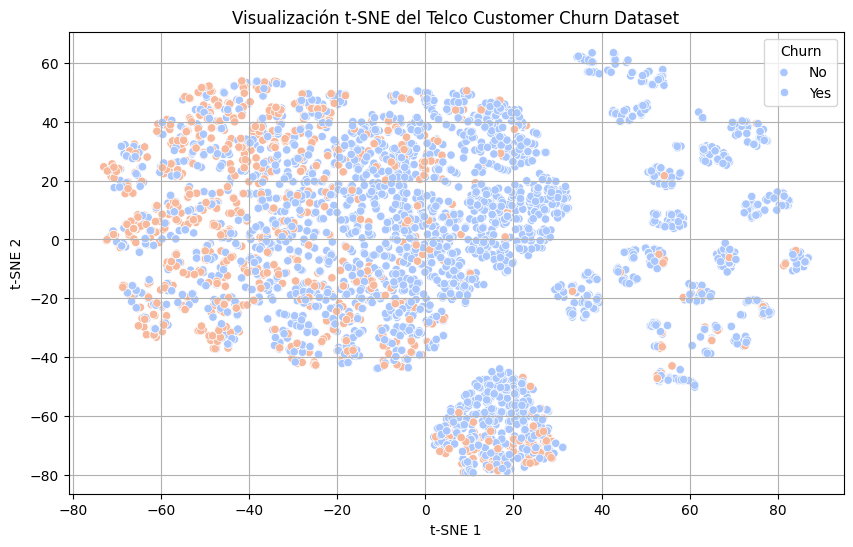

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.pipeline import Pipeline
X = X_train
y = y_train  # etiquetas (opcional para colorear)

tsne = Pipeline([
    ('scaler', StandardScaler()),  # Escalador
    ('tsne', TSNE(n_components=2, random_state=42))  # t-SNE
])
X_tsne = tsne.fit_transform(X_train)

# Visualizar
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='coolwarm', alpha=1)
plt.title("Visualización t-SNE del Telco Customer Churn Dataset")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.grid(True)
plt.show()


### ✅ Actividad 2: Clasificador y Optimización de Hiperparámetros SVM

Cree un clasificador con SVM (ver `SVC`) con kernel RBF.
Use 5-fold cross-validation (ver `GridSearchCV` y  `StratifiedKFold`) para optimizar los siguientes hiperparámetros en el conjunto de entrenamiento (`X_train`, `y_train`):

1. Gamma
2. C


Para la optimización de hiperparámetros utilice como métrica al recall.

Grafique con un mapa de calor 2D donde el eje x es Gamma, el eje y es C y el color es el score.

Una vez optimizados los hiperparámetros, reentrene su clasificador con los mejores hiperparámetros encontrados. Finalmente, evalúe este último clasificador en el conjunto de test ('X_test', 'y_test'.)




Mejores hiperparámetros encontrados:
C = 10.0
Gamma = 0.001
Recall (Validación Cruzada) = 0.7118821437574395


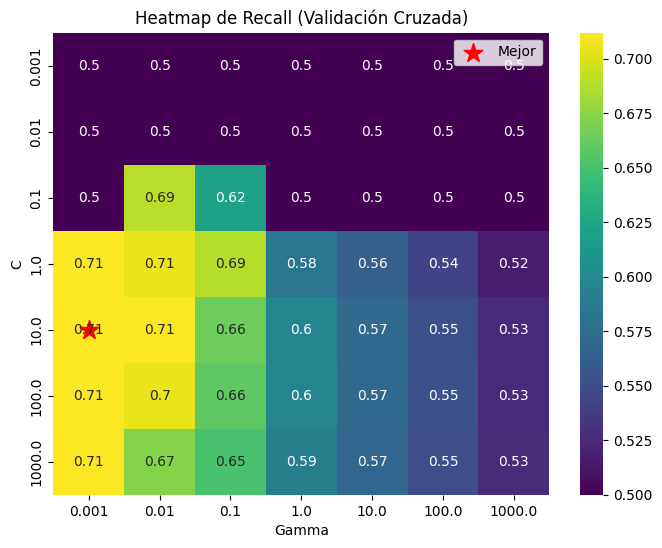

Reporte en conjunto de prueba:

              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.64      0.51      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.78      0.79      0.79      1409



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Crear pipeline: Escalador + SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
])

# Hiperparámetros a optimizar
param_grid = {
    'svm__C': np.logspace(-3, 3, 7),  # Valores de C en escala logarítmica
    'svm__gamma': np.logspace(-3, 3, 7)  # Valores de gamma en escala logarítmica
}

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV con pipeline
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='recall_macro',
    cv=cv,
    n_jobs=-1,
    return_train_score=True
)

# Entrenar
grid_search.fit(X_train, y_train)

# Extraer resultados
results = grid_search.cv_results_
scores = results['mean_test_score']
score_matrix = np.array(scores).reshape(len(param_grid['svm__C']), len(param_grid['svm__gamma']))

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
best_C = best_params['svm__C']
best_gamma = best_params['svm__gamma']

# Mostrar los mejores hiperparámetros
print(f"Mejores hiperparámetros encontrados:")
print(f"C = {best_C}")
print(f"Gamma = {best_gamma}")
print(f"Recall (Validación Cruzada) = {grid_search.best_score_}")

# Encontrar las coordenadas (índices) de los mejores hiperparámetros
best_C_idx = np.where(param_grid['svm__C'] == best_C)[0][0]
best_gamma_idx = np.where(param_grid['svm__gamma'] == best_gamma)[0][0]

# Graficar mapa de calor
plt.figure(figsize=(8, 6))
ax = sns.heatmap(score_matrix, annot=True, xticklabels=param_grid['svm__gamma'],
                 yticklabels=param_grid['svm__C'], cmap='viridis')

# Marcar el mejor punto con una estrella
plt.scatter(x=best_gamma_idx + 0.5, y=best_C_idx + 0.5, s=200, color='red', marker='*', label='Mejor')

plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('Heatmap de Recall (Validación Cruzada)')
plt.legend(loc='upper right')
plt.show()

# Evaluar el mejor modelo en test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Reporte en conjunto de prueba:\n")
print(classification_report(y_test, y_pred))


### ✅ Actividad 3: Clasificador y Optimización de Hiperparámetros Logistic Regression

Repita la actividad 2 pero con Logistic Regression. Bajo el mismo esquema de la actividad anterior, optimice el parámetro de regularización lambda. Utilice una transformación polinomial para garantizar fronteras de decisión no lineal. Compare sus resultados con los obtenidos de la actividad anterior

e:\Users\Documents\Maestria\Semana_2_AS\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Mejor valor de C encontrado: 0.1 (Recall: 0.7214)


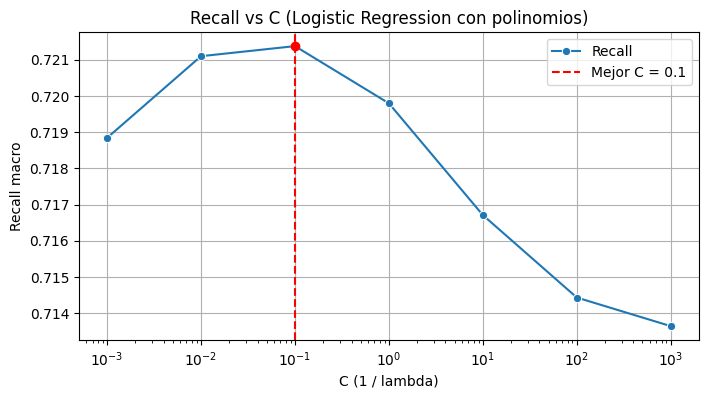

Reporte en conjunto de prueba:

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1035
           1       0.60      0.53      0.57       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.78      0.78      0.78      1409



In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report

# Crear pipeline: polinomio + escalador + regresión logística
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),  # frontera no lineal
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000,penalty='l2'))
])

# Hiperparámetro a optimizar
param_grid = {
    'logreg__C': np.logspace(-3, 3, 7)
}

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearch con recall_macro
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='recall_macro',
    cv=cv,
    n_jobs=-1,
    return_train_score=True
)

# Entrenar
grid_search.fit(X_train, y_train)

# Extraer resultados
scores = grid_search.cv_results_['mean_test_score']
C_values = param_grid['logreg__C']

# Obtener mejor C
best_C = grid_search.best_params_['logreg__C']
best_score = grid_search.best_score_

# Mostrar mejor C
print(f"Mejor valor de C encontrado: {best_C} (Recall: {best_score:.4f})")

# Graficar
plt.figure(figsize=(8, 4))
sns.lineplot(x=C_values, y=scores, marker='o', label='Recall')
plt.axvline(x=best_C, color='red', linestyle='--', label=f'Mejor C = {best_C}')
plt.scatter([best_C], [best_score], color='red', zorder=5)
plt.xscale('log')
plt.xlabel('C (1 / lambda)')
plt.ylabel('Recall macro')
plt.title('Recall vs C (Logistic Regression con polinomios)')
plt.grid(True)
plt.legend()
plt.show()

# Mejor modelo
best_model = grid_search.best_estimator_

# Evaluar en test
y_pred = best_model.predict(X_test)
print("Reporte en conjunto de prueba:\n")
print(classification_report(y_test, y_pred))


# Conclucion 
En comparacion el score con el ejercicio anterior son muy parecidos, sin  embargo hay mas flexibilidad debido a que tiene mas hiperamaetros
S i se sube el grado, el procesamiento no conveergue y el costo computaciona les mas elevado 

### ✅ Actividad 4: Bayesian Optimization

Repetir la actividad 2 usando Bayesian Optimization

Tip: usar BayesSearchCV

https://machinelearningmastery.com/scikit-optimize-for-hyperparameter-tuning-in-machine-learning/


Mejores hiperparámetros encontrados:
OrderedDict([('svm__C', 1000.0), ('svm__gamma', 0.0005353369325521562)])
Mejor recall (validación cruzada): 0.7143

Reporte en conjunto de prueba:

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.51      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



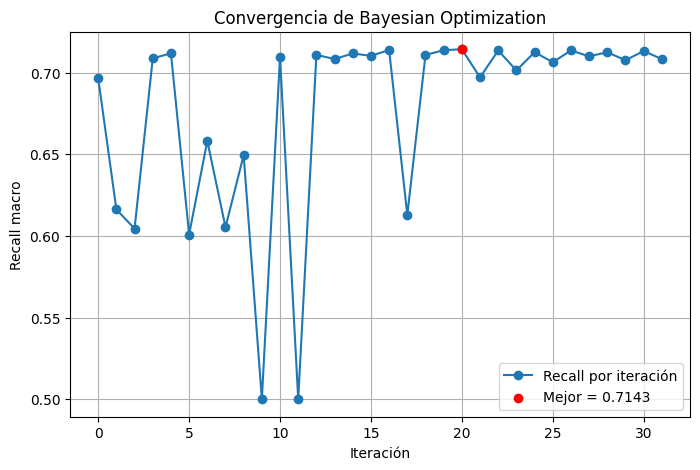

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from skopt import BayesSearchCV
from skopt.space import Real


# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
])

# Espacio de búsqueda
search_spaces = {
    'svm__C': Real(1e-2, 1e3, prior='log-uniform'),
    'svm__gamma': Real(1e-4, 1e0, prior='log-uniform')
}

# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_spaces,
    n_iter=32,
    scoring='recall_macro',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

# Ajuste
opt.fit(X_train, y_train)

# Mostrar mejores hiperparámetros y score
print("Mejores hiperparámetros encontrados:")
print(opt.best_params_)
print(f"Mejor recall (validación cruzada): {opt.best_score_:.4f}")

# Evaluar en test
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)
print("\nReporte en conjunto de prueba:\n")
print(classification_report(y_test, y_pred))

# Graficar convergencia con mejor punto
scores = opt.cv_results_['mean_test_score']
best_idx = np.argmax(scores)

plt.figure(figsize=(8, 5))
plt.plot(scores, marker='o', label='Recall por iteración')
plt.scatter(best_idx, scores[best_idx], color='red', label=f'Mejor = {scores[best_idx]:.4f}', zorder=5)
plt.xlabel('Iteración')
plt.ylabel('Recall macro')
plt.title('Convergencia de Bayesian Optimization')
plt.legend()
plt.grid(True)
plt.show()


# Conclucion 

A comparacion de los otros 2 ese es mas propenso al ruido, sin embargo converge al mismo valor 